## Functions etc.

In [83]:
# nest
import nest
import nest.raster_plot
import nest.voltage_trace
import random
# other
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import json
import time 
import timeit
import itertools
import numpy as np
np.set_printoptions(suppress=True)
from importlib import reload 
from itertools import permutations 
from itertools import combinations 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("white")

# fitting distributions
import plfit
from plfit import plfit
import powerlaw
import scipy

import LeakySimulator as sim
reload(sim);

np.random.seed(1)
# initialise useful functions
U = sim.Usefulfunctions()

In [2]:
def set_params(J_ex=6., J_in=-95., C_m=250.0, NE=960, NI=240, stim_end=100., simtime=1100.):
    
    sim_params = {

            'N_total':1200,
            'NE': 960, # Default:## 4/5 are exci neurons, 1/5 are inh neurons
            'NI': 240,
            'eps':0.1,  # connection probability
            'J_in':-95.0,
            'J_ex':6.0,
            'resolution':0.1,  # temporal resolution of simulation in ms. Kumar2008: 0.1
            'delay':1.5,  # synaptic delay in the network
            'n_threads':8,
            'stim_start':0., # start applying current (dc)
            'stim_end':100., # end applying current (dc)
            'simtime':1100., # simulation time 
            'sub_fr':0.9, # subthreshold current amplitude
            'sup_fr':1.01, # suprathreshold current amplitude
        }

    model_params = {

            'C_m': 250.0,
            'E_L': -70.0,
            'E_ex': 0.0,
            'E_in': -80.0,
            'I_e': 0.0,
            'V_reset': -70.0,
            'V_th': -50.0,
            'g_L': 16.7,
            't_ref': 2.0, # Duration of refractory period
            'tau_syn_ex': 0.326, # Rise time of the excitatory synaptic alpha function
            'tau_syn_in': 0.326,
        }

    # parameters for STDP synapses
    syn_params_ex = {

            'model':'stdp_synapse',
            'lambda': 0.01,
            'alpha': 1.0,
            'delay': 1.5,
            'weight': 6.0,
            'Wmax': 100.0   
        }

    syn_params_in = {

            'model':'stdp_synapse',
            'lambda': 0.01,
            'alpha': 1.0,
            'delay': 1.5,
            'weight':-95.0,
            'Wmax':-100.0  
        }
     
    sim_params['NE'] = NE
    sim_params['NI'] = NI
    sim_params['J_in'] = J_in
    sim_params['J_ex'] = J_ex
    sim_params['C_m'] = C_m
    sim_params['simtime'] = simtime
    
    syn_params_ex['weight'] = J_ex
    syn_params_in['weight'] = J_in
    
    return sim_params, model_params, syn_params_ex, syn_params_in

In [3]:
patterns = []
# make permutations for 8 bit pattern
for perm in U.make_permutations():
    patterns.append(perm)

In [4]:
def simulate_for_all(patterns):
    '''
    Run simulation for all 70 patterns.
    Returns list of lists. (nested list)
    '''
    spikedet_lst = []
    multimet_lst = []

    spike_times_lst = []
    spike_neurons_lst = []
    events_lst = []
    times_lst = []

    for p in patterns:

        LS.set_pattern(p)

        spikedet, multimet, spike_times, spike_neurons, events, etimes = LS.simulate() # get simulation data 
        
        # store data from this run
        spikedet_lst.append(spikedet)
        multimet_lst.append(multimet)
        spike_times_lst.append(spike_times)
        spike_neurons_lst.append(spike_neurons)
        events_lst.append(events)
        times_lst.append(etimes)

    return spikedet_lst, multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst


def get_transient_data(spike_times_lst, sim_params):

    '''
    given a nested list spike times & spike neurons, returns transient metrics for each n patterns.

    RETURNS:

        fr_avg_lst: the FR per stimulation pattern
        transient_lifetime_lst: the transient duration per stimulation pattern
        transient_size_lst: the transient size per stimulation pattern
    '''

    # make lists to store data
    fr_avg_lst = []
    transient_lifetime_lst = []
    transient_size_lst = []

    stim_end = sim_params['stim_end'] # get the stimulation end
    num_neurons = sim_params['N_total']

    for i in range(len(spike_times_lst)):

        spike_times = spike_times_lst[i] # choose one list of lists 

        # the transient starts AFTER the stimulation. So we only want the data after 100 ms (stim_end)
        transient_indices = np.where(spike_times > stim_end) # stim_time = 100 ms
        transient_times = (spike_times[transient_indices]) - stim_end
        
        # --- TRANSIENT LIFETIME ---
        transient_lifetime = max(transient_times) # largest number in the list is the duration in ms
        # --- GET TRANSIENT SIZE ---
        transient_size = len(transient_times) # count total number of spikes
        # --- POPULATION FR ---
        fr_avg = round((transient_size/num_neurons),2) # num spikes / num neurons 

        # store the data for this run
        fr_avg_lst.append(fr_avg)
        transient_lifetime_lst.append(transient_lifetime)
        transient_size_lst.append(transient_size)
    
    return fr_avg_lst, transient_lifetime_lst, transient_size_lst

    
def get_metrics(transient_lifetime_lst, transient_size_lst):
    '''
    From these 70 simulations: return the min, median and maximum transient metrics.
    '''
    # convert lists to numpy arrays
    transient_lifetime_arr = np.array(transient_lifetime_lst)
    transient_size_arr = np.array(transient_size_lst)

    # === TRANSIENT LIFETIME
    tl_min = round(min(transient_lifetime_arr),2)
    tl_median = np.median(transient_lifetime_arr)
    tl_max = round(max(transient_lifetime_arr),2)
    tl_std = round(np.std(transient_lifetime_arr),2)
    tl_mean = round(np.mean(transient_lifetime_arr),2)

    # === TRANSIENT SIZE
    ts_min = round(min(transient_size_arr),2)
    ts_median = np.median(transient_size_arr)
    ts_max = round(max(transient_size_arr),2)
    ts_std = round(np.std(transient_size_arr),2)
    ts_mean = round(np.mean(transient_size_arr),2)

    transient_lifetime_metrics = [tl_min, tl_median, tl_max, tl_std, tl_mean]
    transient_size_metrics = [ts_min, ts_median, ts_max, ts_std, ts_mean]

    return transient_lifetime_metrics, transient_size_metrics

In [5]:
range_J_ex = [6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4] # default value: 6.0
range_J_in = [-62., -61., -60., -59., -58., -57., -56., -55., -54., -53. ,-52., -51., -50., -49., -48., -47., -46., -45., -44.,-43., -42., -41.]
range_stim_durations = [25., 50., 75., 100., 125., 150.]

# generate k equally distributed values between
range_J_in_small_dt = np.arange(-48, -44, 0.05)

len(range_J_in_small_dt)

80

# Balancing excitation and inhibition

In [48]:
# === set parameter you want to change ===
parameter_range = range_J_in

# ======= #
TL_metrics_lst = []
TS_metrics_lst = []

for x in parameter_range:
    
    # === set the parameters ===
    sim_params, model_params, syn_params_ex, syn_params_in = set_params(J_in=x, simtime=2000.)
    
    # === initialise class with these parameters ===
    LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
    LS.build_network() # build network
    
    # === run the simulations ===
    spikedet_lst, multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst = simulate_for_all(patterns)

    # === spoon out the data we need for all 70 patterns === 
    fr_avg_lst, transient_lifetime_lst, transient_size_lst = get_transient_data(spike_times_lst, sim_params)
    
    # === get metrics ===
    transient_lifetime_metrics, transient_size_metrics = get_metrics(transient_lifetime_lst, transient_size_lst)

    # collect data 
    TL_metrics_lst.append(transient_lifetime_metrics)
    TS_metrics_lst.append(transient_size_metrics)
    
    print(f'simulation epoch for {x} done')

simulation epoch for -62.0 done
simulation epoch for -61.0 done
simulation epoch for -60.0 done
simulation epoch for -59.0 done
simulation epoch for -58.0 done
simulation epoch for -57.0 done
simulation epoch for -56.0 done
simulation epoch for -55.0 done
simulation epoch for -54.0 done
simulation epoch for -53.0 done
simulation epoch for -52.0 done
simulation epoch for -51.0 done
simulation epoch for -50.0 done
simulation epoch for -49.0 done
simulation epoch for -48.0 done
simulation epoch for -47.0 done
simulation epoch for -46.0 done
simulation epoch for -45.0 done
simulation epoch for -44.0 done
simulation epoch for -43.0 done
simulation epoch for -42.0 done
simulation epoch for -41.0 done


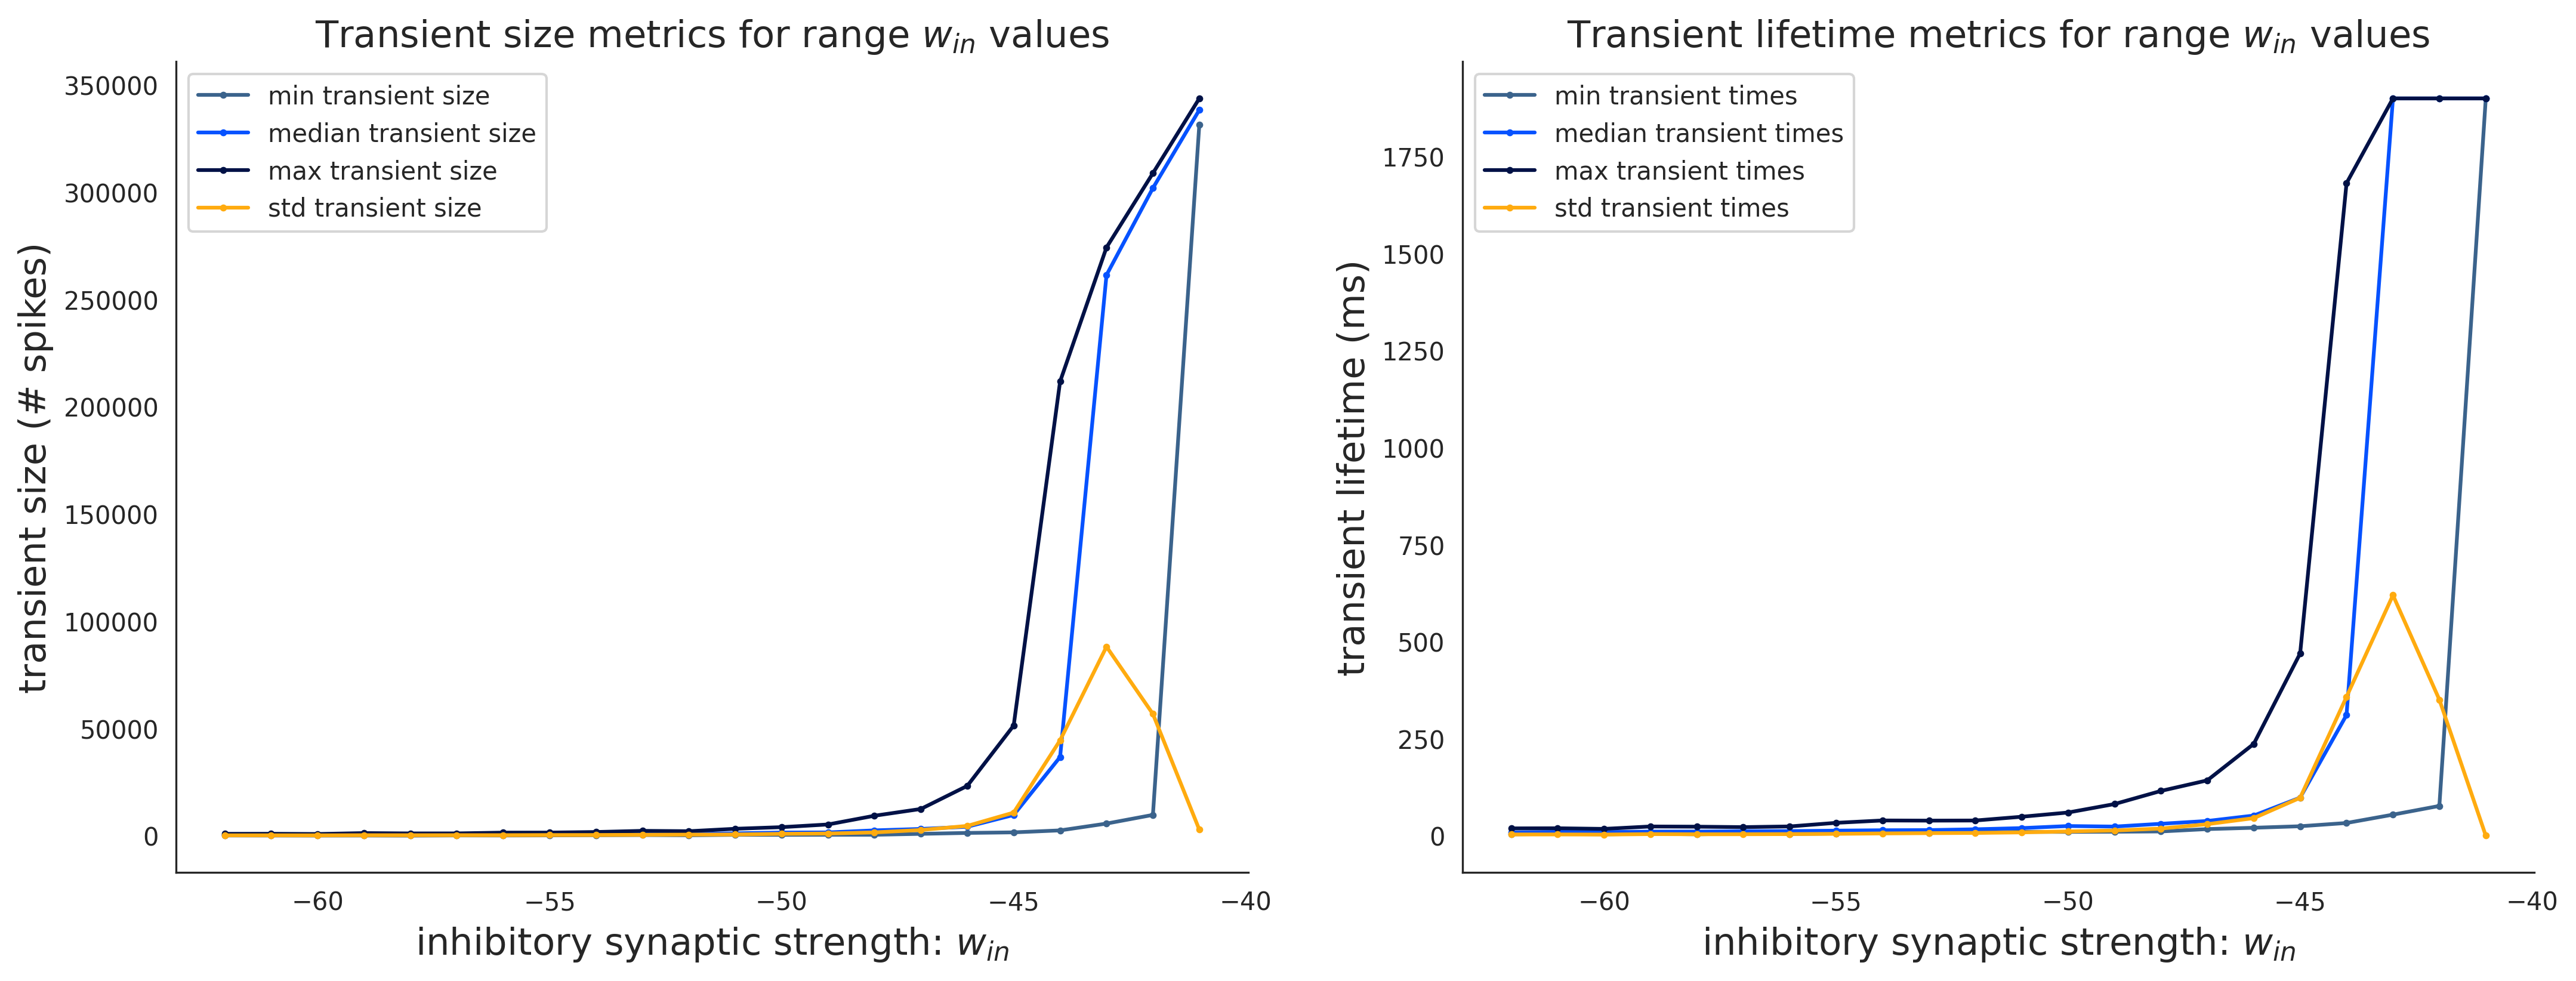

In [53]:
x_axis_name = 'inhibitory synaptic strength: $w_{in}$'

# put them in separate lists 
TL_min = [i[0] for i in TL_metrics_lst]
TL_median = [i[1] for i in TL_metrics_lst]
TL_max = [i[2] for i in TL_metrics_lst]
TL_std = [i[3] for i in TL_metrics_lst]

TS_min = [i[0] for i in TS_metrics_lst]
TS_median = [i[1] for i in TS_metrics_lst]
TS_max = [i[2] for i in TS_metrics_lst]
TS_std = [i[3] for i in TS_metrics_lst]

ms = 1.8
lw = 1.5
# === Plot ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,6), dpi=300)
ax1.plot(parameter_range, TS_min , '-o', color='xkcd:denim', label='min transient size', linewidth=lw, markersize=ms);
ax1.plot(parameter_range, TS_median, '-o', color='xkcd:electric blue', label ='median transient size',linewidth=lw, markersize=ms);
ax1.plot(parameter_range, TS_max, '-o', color='xkcd:navy blue', label='max transient size',linewidth=lw, markersize=ms);
ax1.plot(parameter_range, TS_std, '-o', color="#ffab0f", label='std transient size', linewidth=lw, markersize=ms);
ax1.set_xlabel(x_axis_name, fontsize=15)
ax1.set_ylabel('transient size (# spikes)', fontsize=15)
ax1.set_title('Transient size metrics for range $w_{in}$ values', fontsize=15)
ax1.legend();
# Remove top and right borders
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yscale('linear')

ax2.plot(parameter_range, TL_min, '-o', color='xkcd:denim', label ='min transient times', linewidth=lw, markersize=ms);
ax2.plot(parameter_range, TL_median, '-o', color='xkcd:electric blue', label ='median transient times', linewidth=lw, markersize=ms);
ax2.plot(parameter_range, TL_max,'-o', color='xkcd:navy blue', label='max transient times', linewidth=lw, markersize=ms);
ax2.plot(parameter_range, TL_std, '-o', color="#ffab0f", label='std transient times', linewidth=lw, markersize=ms);
ax2.set_xlabel(x_axis_name, fontsize=15);
ax2.set_ylabel('transient lifetime (ms)', fontsize=15)
ax2.legend();
ax2.set_title('Transient lifetime metrics for range $w_{in}$ values', fontsize=15)
#ax2.set_xticks(xticks)
# Remove top and right borders
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False);
ax2.set_yscale('linear')

# Plot transient size and transient lifetime means

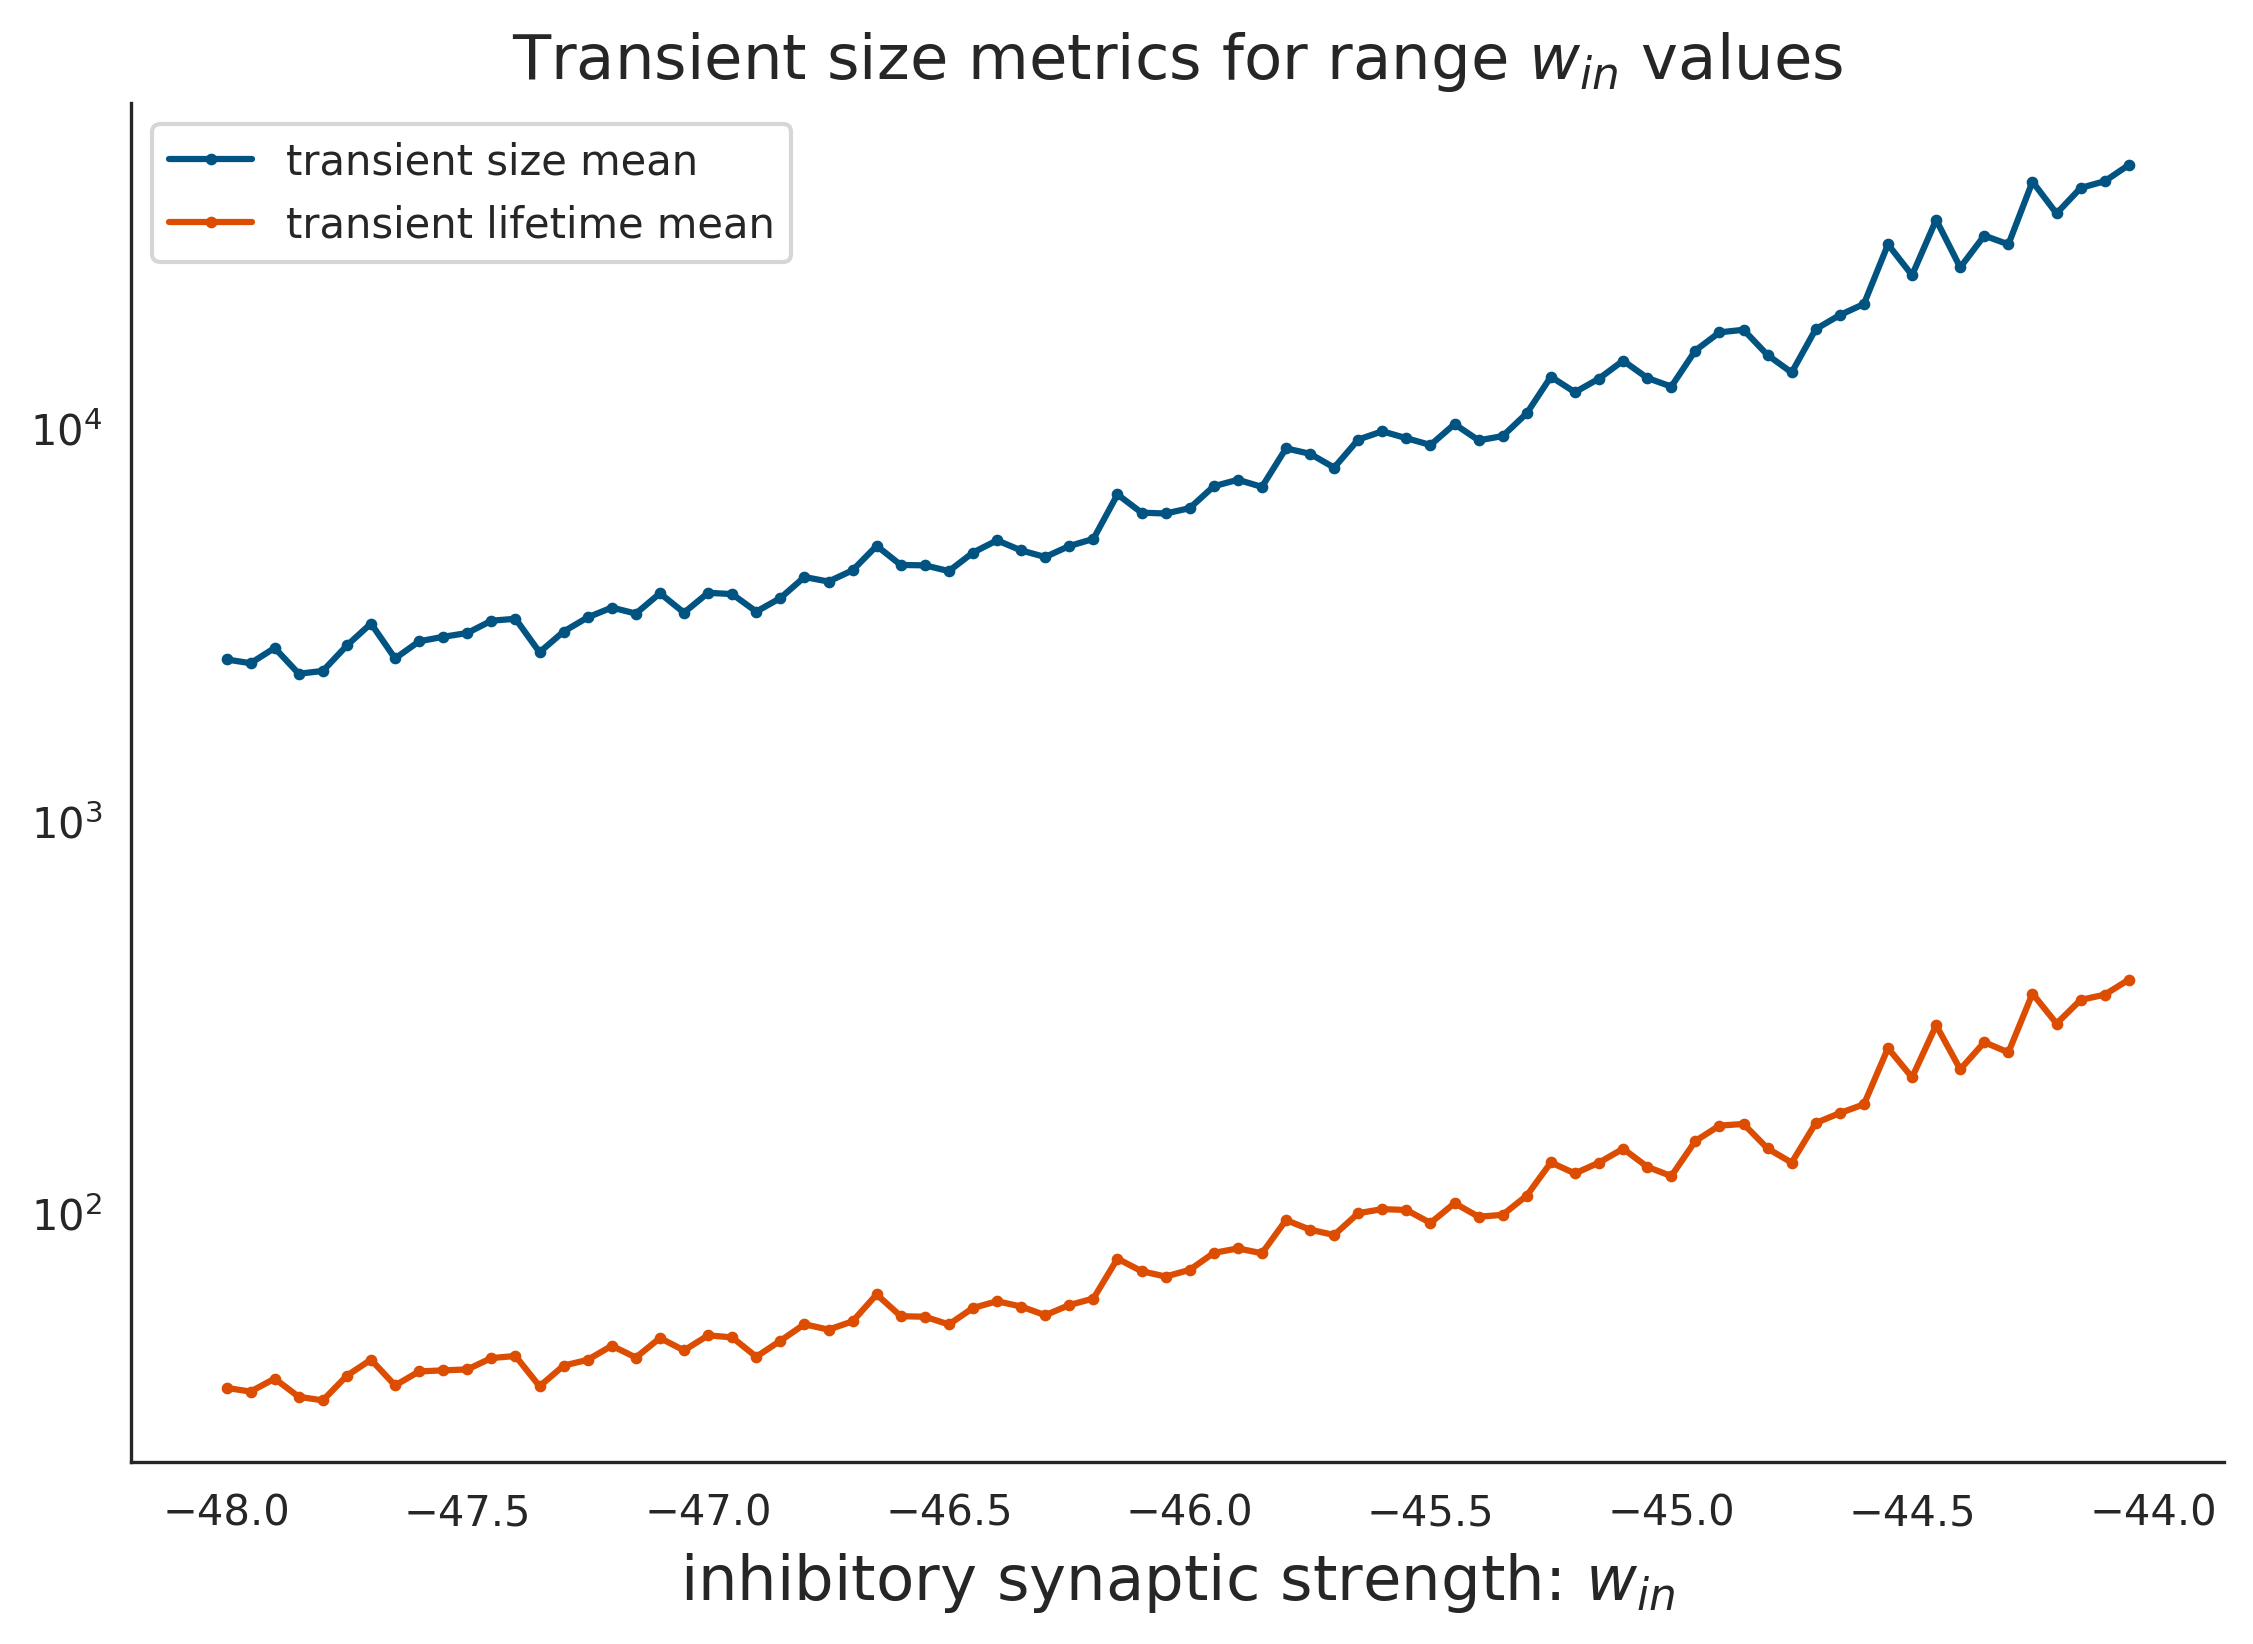

In [47]:
TL_mean = [i[4] for i in TL_metrics_lst]
TS_mean = [i[4] for i in TS_metrics_lst]

ms = 1.8
lw = 1.5
# === Plot ===
fig, ax1 = plt.subplots(1, 1, figsize=(9,6), dpi=300)
ax1.plot(parameter_range, TS_mean, '-o', color='xkcd:deep sea blue', label ='transient size mean',linewidth=lw, markersize=ms);
ax1.plot(parameter_range, TL_mean, '-o', color="xkcd:deep orange", label='transient lifetime mean', linewidth=lw, markersize=ms);
ax1.set_xlabel(x_axis_name, fontsize=15)
ax1.set_title('Transient size metrics for range $w_{in}$ values', fontsize=15)
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yscale('log')

# Transient distributions

In [6]:
parameter_range = [-44.0 , -45.0, -46.0, -47.0, -48.0]

# ======= #
transient_lifetime_lst = []
transient_size_lst = []

for x in parameter_range:
    
    # === set the parameters ===
    sim_params, model_params, syn_params_ex, syn_params_in = set_params(J_in=x, simtime=2000.)
    
    # === initialise class with these parameters ===
    LS = sim.LeakySimulator(sim_params, model_params, syn_params_ex, syn_params_in)
    LS.build_network() # build network
    
    # === run the simulations ===
    spikedet_lst, multimet_lst, times_lst, events_lst, spike_times_lst, spike_neurons_lst = simulate_for_all(patterns)
    
    # reorder the spikes
    ordered_spike_neurons_lst = []

    for i in range(len(spike_neurons_lst)):
        # reorder the spikes
        NO_i = U.reorder(spike_neurons_lst[i])
        ordered_spike_neurons_lst.append(NO_i)

    # distributions
    fr_avg_lst, transient_lifetime, transient_size = get_transient_data(spike_times_lst, sim_params)
    
    # collect data 
    transient_lifetime_lst.append(transient_lifetime)
    transient_size_lst.append(transient_size)

## Histograms

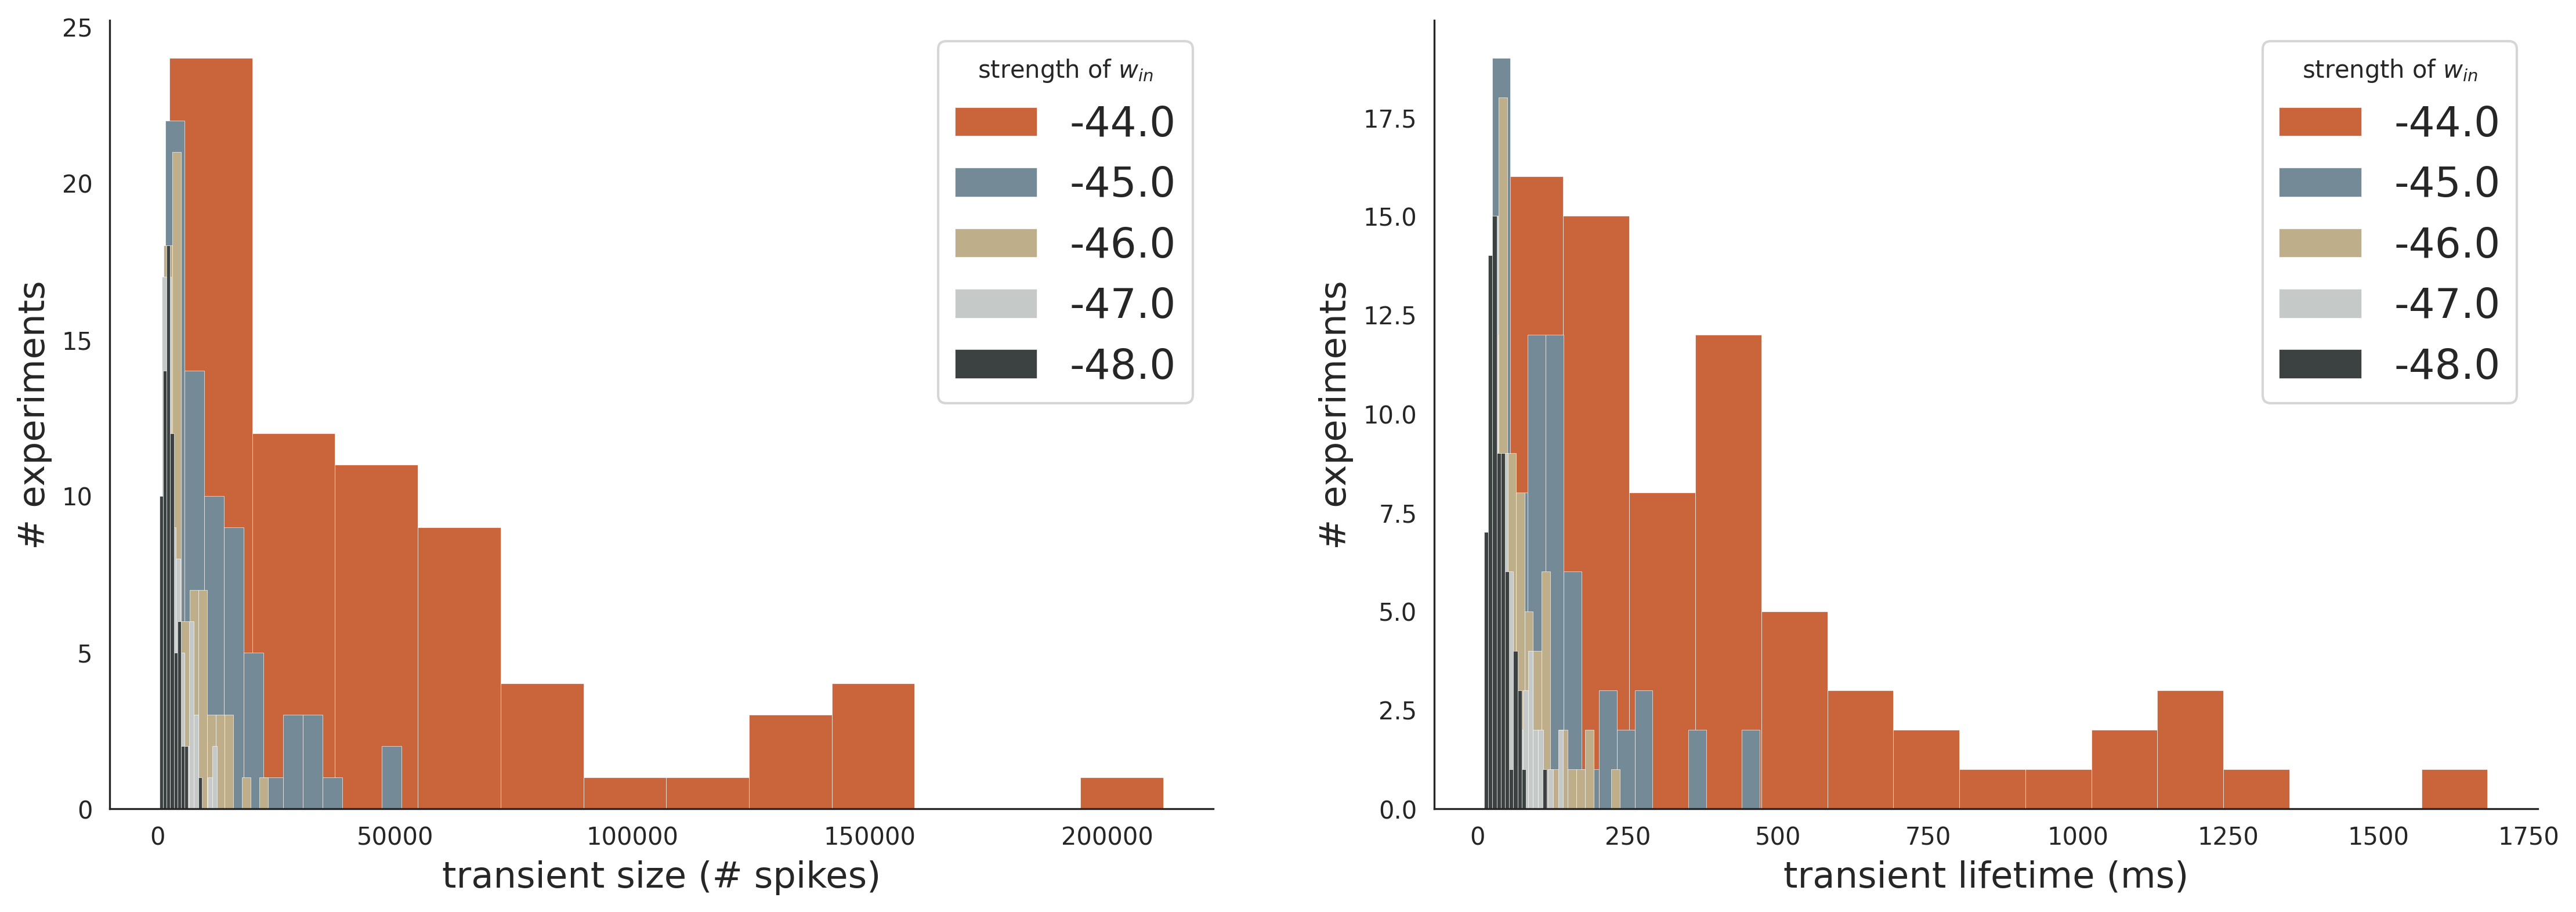

In [70]:
# List of five airlines to plot
param_range = [-44.0 , -45.0, -46.0, -47.0, -48.0]
# Create an array with the colors you want to use
#colors = ["#3eaf76", "#0652FF","#FF474C", "#00035b", "#ffab0f"]
colors = ['#c9643b', '#748b97', '#beae8a', '#c5c9c7','#3c4142' ]
# pink .......
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6), dpi=300)
for i,p in enumerate(param_range):

    transient_size = transient_size_lst[i]
    transient_lifetime = transient_lifetime_lst[i]
    
    sns.distplot(transient_size, ax=ax1, kde=False, bins=12, label = p, hist_kws={"linewidth": 0.15, "alpha": 1})
    ax1.set_xlabel('transient size (# spikes)', fontsize=15)
    ax1.set_ylabel('# experiments', fontsize=15)
    ax1.legend(title='strength of $w_{in}$', fontsize=17);
    # Remove top and right borders
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    sns.distplot(transient_lifetime, ax=ax2, kde=False, bins=15, label = p, hist_kws={"linewidth": 0.15, "alpha": 1})
    ax2.set_xlabel('transient lifetime (ms)', fontsize=15)
    ax2.set_ylabel('# experiments', fontsize=15)  
    ax2.legend(title='strength of $w_{in}$', fontsize=17);
    # Remove top and right borders
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

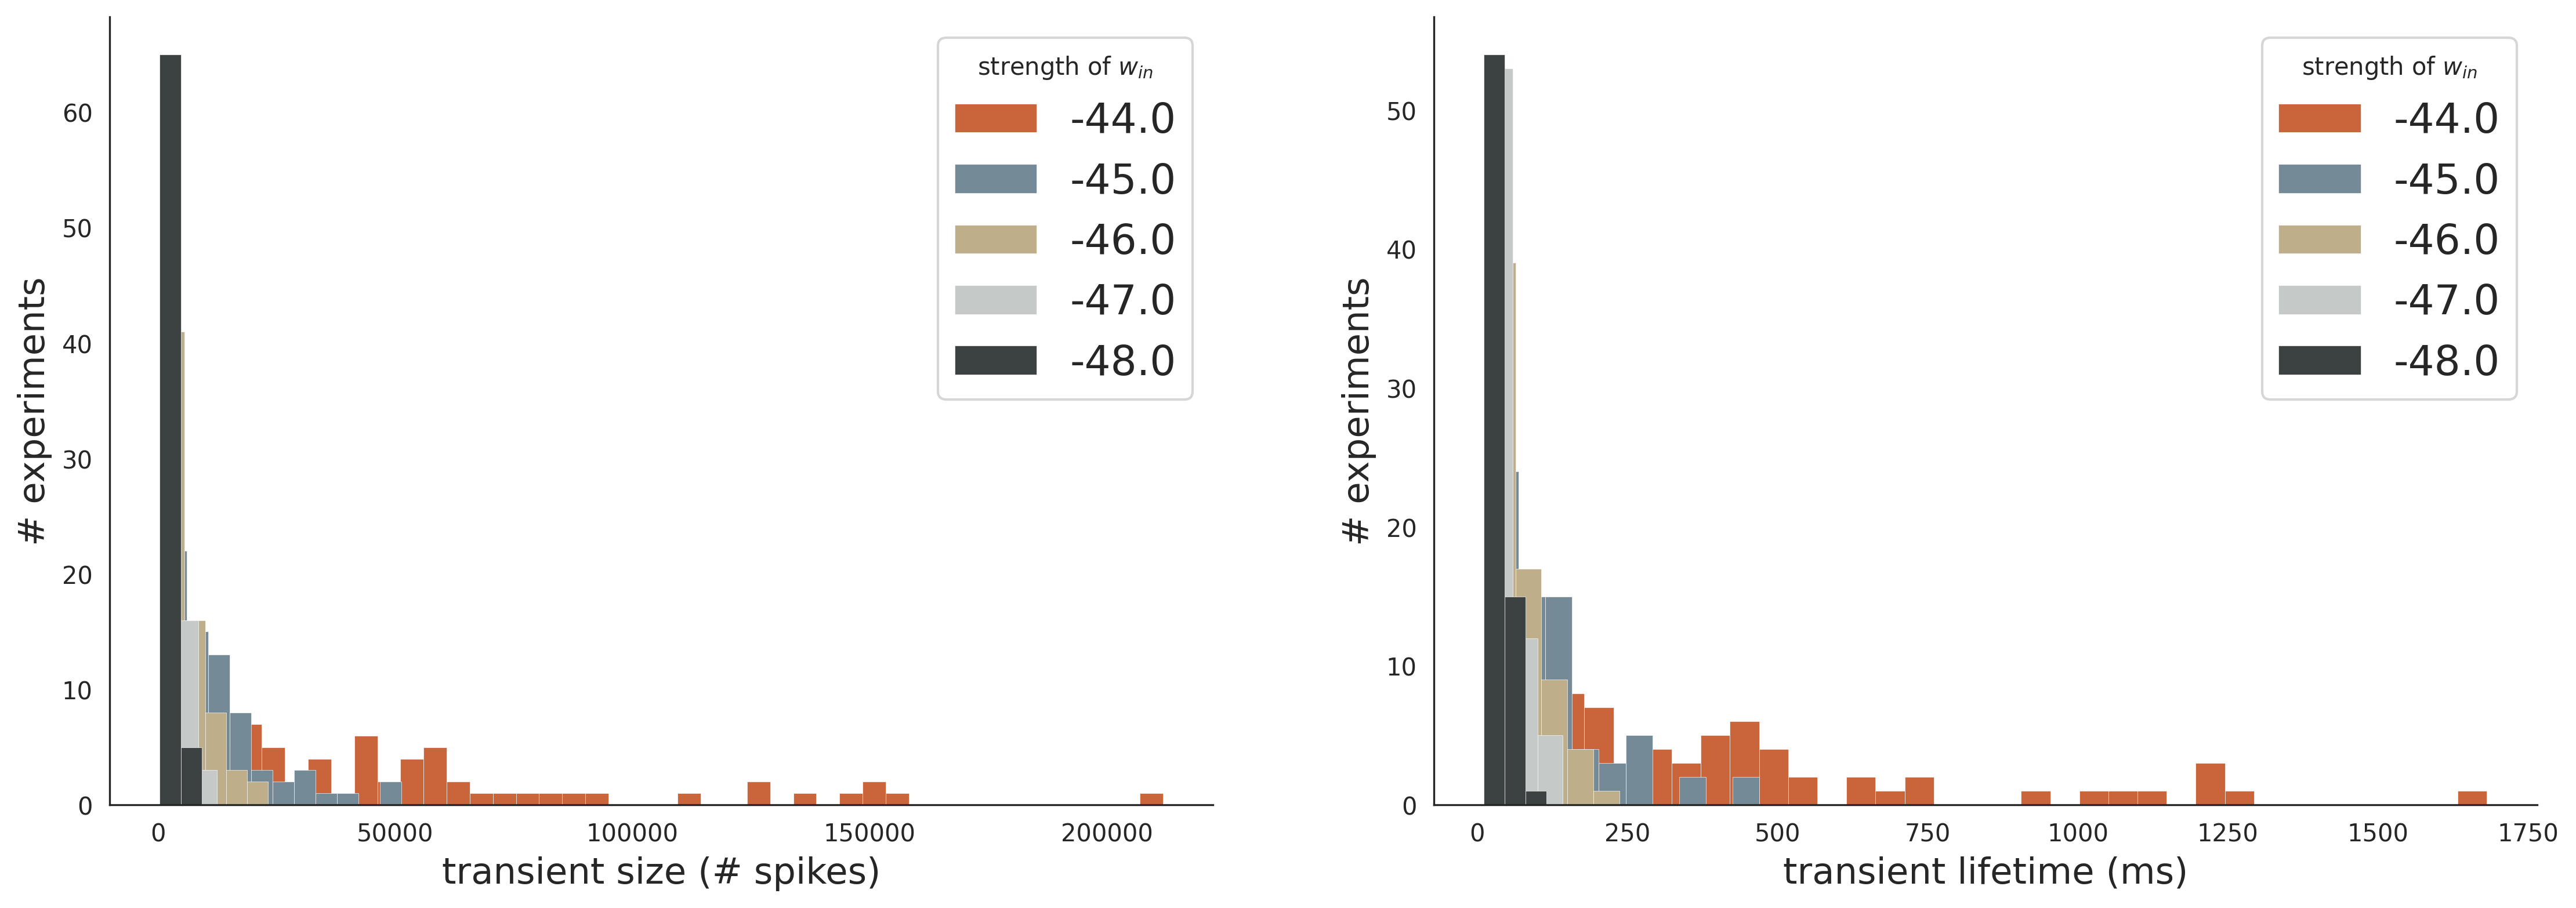

In [81]:
import math

# List of five airlines to plot
param_range = [-44.0, -45.0, -46.0, -47.0, -48.0]
# Create an array with the colors you want to use
#colors = ["#3eaf76", "#0652FF","#FF474C", "#00035b", "#ffab0f"]
colors = ['#c9643b', '#748b97', '#beae8a', '#c5c9c7','#3c4142' ]
# pink .......
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6), dpi=300)
for i,p in enumerate(param_range):

    transient_size = transient_size_lst[i]
    transient_lifetime = transient_lifetime_lst[i]
    
    sns.distplot(transient_size, ax=ax1, kde=False, bins=math.ceil(max(transient_size)/5000), label = p, hist_kws={"linewidth": 0.15, "alpha": 1})
    ax1.set_xlabel('transient size (# spikes)', fontsize=15)
    ax1.set_ylabel('# experiments', fontsize=15)
    ax1.legend(title='strength of $w_{in}$', fontsize=17);
    # Remove top and right borders
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    sns.distplot(transient_lifetime, ax=ax2, kde=False, bins=math.ceil(max(transient_lifetime)/50), label = p, hist_kws={"linewidth": 0.15, "alpha": 1})
    ax2.set_xlabel('transient lifetime (ms)', fontsize=15)
    ax2.set_ylabel('# experiments', fontsize=15)  
    ax2.legend(title='strength of $w_{in}$', fontsize=17);
    # Remove top and right borders
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

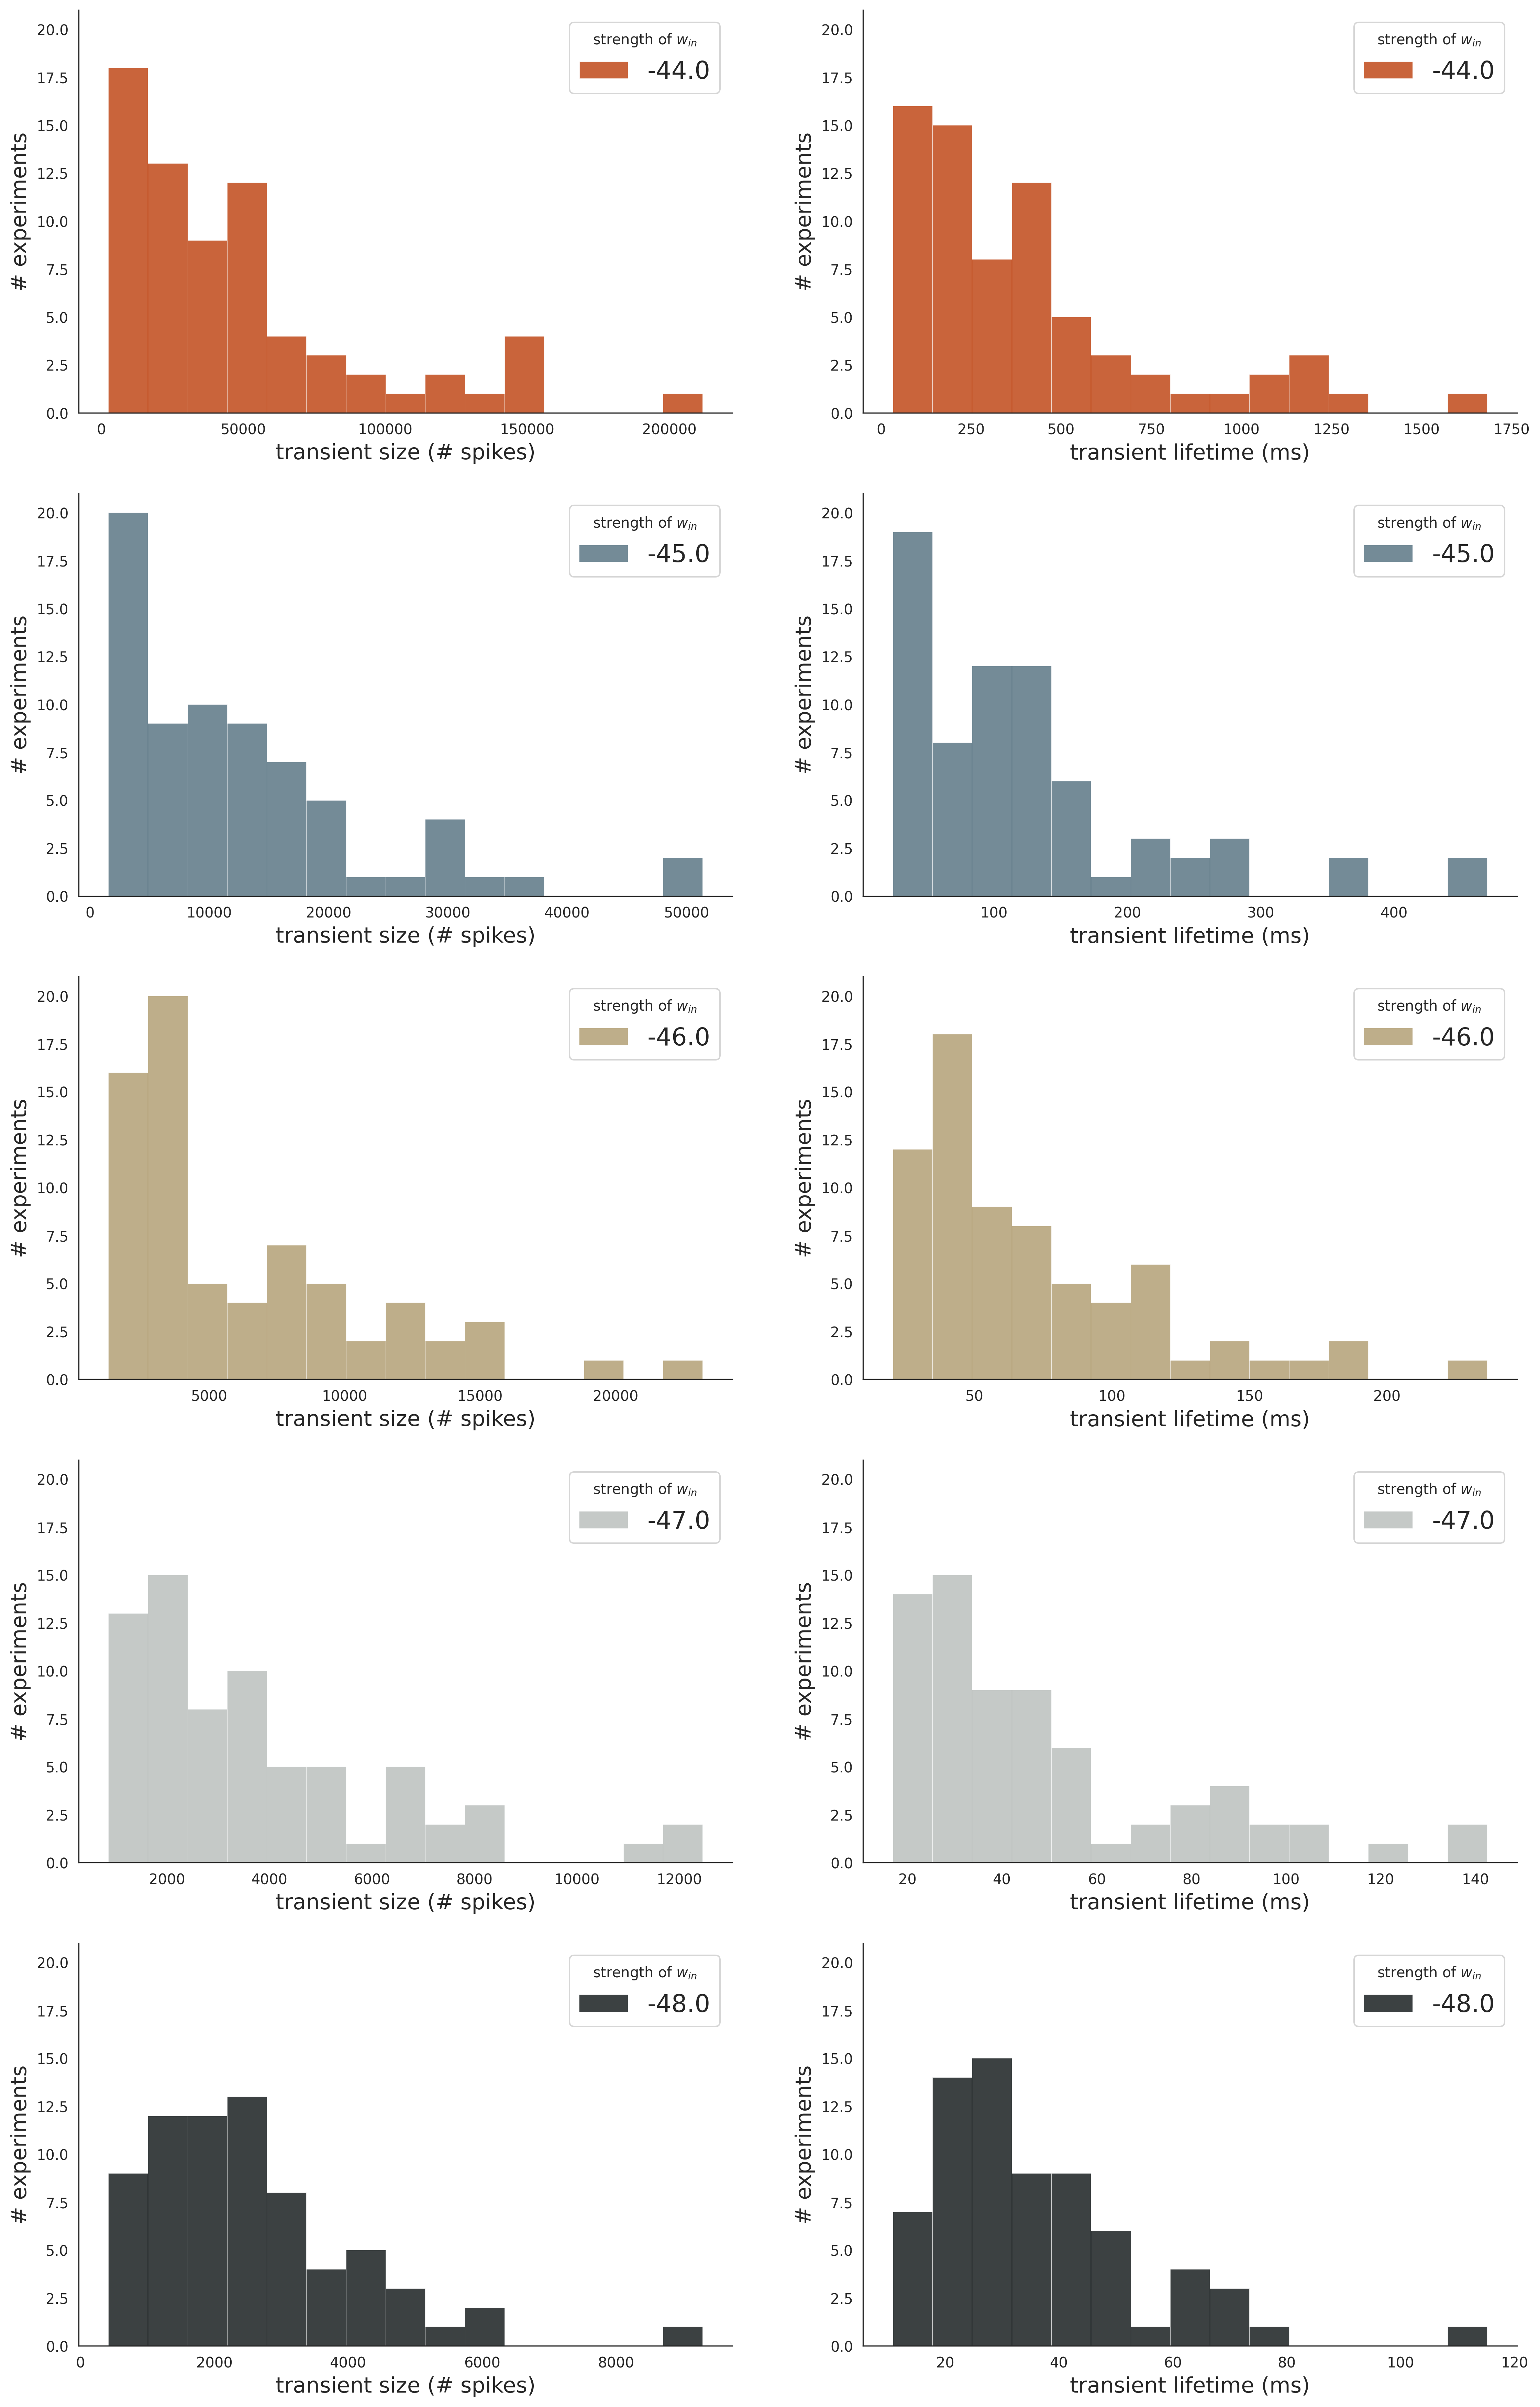

In [144]:
num_experiments = 70
steps = 15

f, axs = plt.subplots(nrows=len(param_range), ncols=2, sharey=True, figsize=(9 * 2, len(param_range) * 6), dpi=300)
for i,p in enumerate(param_range):

    transient_size = transient_size_lst[i]
    transient_lifetime = transient_lifetime_lst[i]
    
    sns.distplot(
        a=transient_size,
        ax=axs[i,0],
        kde=False,
        bins=15,
        label=p,
        hist_kws={"linewidth": 0.15, "alpha": 1},
        color=colors[i]
    )
    axs[i,0].set_xlabel('transient size (# spikes)', fontsize=15)
    axs[i,0].set_ylabel('# experiments', fontsize=15)
    axs[i,0].legend(title='strength of $w_{in}$', fontsize=17);
    # Remove top and right borders
    axs[i,0].spines['top'].set_visible(False)
    axs[i,0].spines['right'].set_visible(False)

    sns.distplot(
        a=transient_lifetime,
        ax=axs[i,1],
        kde=False,
        bins=15,
        label=p,
        hist_kws={"linewidth": 0.15, "alpha": 1},
        color=colors[i])
    axs[i,1].set_xlabel('transient lifetime (ms)', fontsize=15)
    axs[i,1].set_ylabel('# experiments', fontsize=15)  
    axs[i,1].legend(title='strength of $w_{in}$', fontsize=17);
    # Remove top and right borders
    axs[i,1].spines['top'].set_visible(False)
    axs[i,1].spines['right'].set_visible(False)
    
for ax in axs.flatten():
    ax.yaxis.set_tick_params(labelleft=True)

## KDE

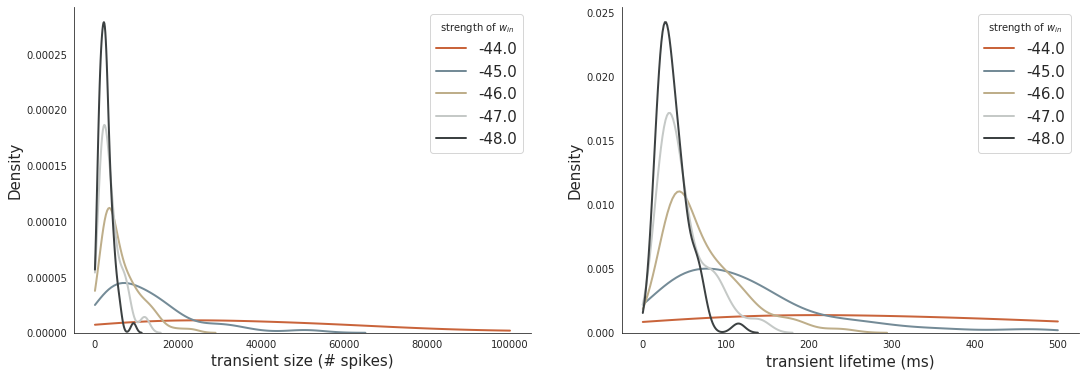

In [98]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
for i,p in enumerate(param_range):

    transient_size = transient_size_lst[i]
    transient_lifetime = transient_lifetime_lst[i]
    
    #sns.distplot(transient_size, ax=ax1, kde=True, hist=False, bins=12, kde_kws={"lw":3}, label=p, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
    sns.kdeplot(transient_size, ax=ax1, label=p, kernel='gau', clip=(0,100000), linewidth=2)
    ax1.set_xlabel('transient size (# spikes)', fontsize=15)
    ax1.set_ylabel('Density', fontsize=15)
    ax1.legend(title='strength of $w_{in}$', fontsize=15);
    # Remove top and right borders
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    sns.kdeplot(transient_lifetime, ax=ax2, label=p, kernel='gau', clip=(0,500), linewidth=2)
    #sns.distplot(transient_lifetime, ax=ax2, kde=True, hist=False, bins=12, kde_kws = {'linewidth':3}, label = p)
    ax2.set_xlabel('transient lifetime (ms)', fontsize=15)
    ax2.set_ylabel('Density', fontsize=15)
    ax2.legend(title='strength of $w_{in}$', fontsize=15);
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False);

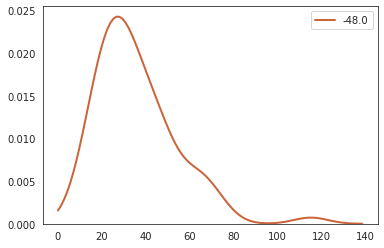

In [137]:
transient_size = transient_size_lst[4]
transient_lifetime = transient_lifetime_lst[4]

#sns.kdeplot(transient_size, label=p, kernel='gau', clip=(0,100000), linewidth=2)
sns.kdeplot(transient_lifetime, label=p, kernel='gau', clip=(0,100000), linewidth=2)

# Power law fitting

### 3.4 A Testing the power law hypothesis

**Recipe for analysing power-law distributed data** (Adapted from Clauset et al., 2009)

1. Estimate the parameters $x_{min}$ and $\alpha$ 
2. Calculate the goodness of fit between the data and the power law.
    - If $p > 0.1$: it is plausible that your data follows a power law distribution.
    - Else: it doesn't follow a power law distribution.

In [160]:
parameter_range = [-44.0 , -45.0, -46.0, -47.0, -48.0]

# choose an index (because I have a list of lists)
# we will now analyse whether the distributions fit a power law 
idx = 0

# get the right value for j_in and transient data
value = parameter_range[idx]
transient_lifetime_idx = transient_lifetime_lst[idx]
transient_size_idx = transient_size_lst[idx]

print(f'Fitting distributions for J_in = {value}')

Fitting distributions for J_in = -44.0


### transient life time

PYTHON plfit executed in 0.004652 seconds
xmin: 86.6 n(>xmin): 63 alpha: 1.74907 +/- 0.0943739   Log-Likelihood: -446.368   ks: 0.209391 p(ks): 0.00334322


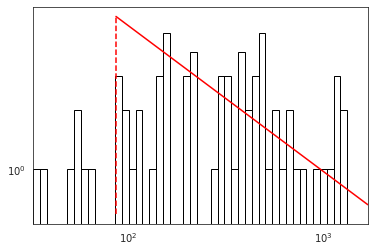

In [161]:
fit = plfit(transient_lifetime_idx, discrete=False)

# plot pdf and powerlaw (red)
fit.plotpdf()

### transient size

PYTHON plfit executed in 0.005445 seconds
xmin: 10401 n(>xmin): 62 alpha: 1.74398 +/- 0.0944854   Log-Likelihood: -737.151   ks: 0.196653 p(ks): 0.00706666


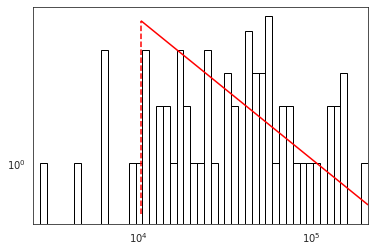

In [162]:
fit = plfit(transient_size_idx, discrete=False)

# plot pdf and powerlaw (red)
fit.plotpdf()

### 3.4 B Comparing distributions

$R$ is the loglikelihood ratio between the two candidate distributions. The likelihood-ratio test assesses the **goodness of fit** of two competing statistical models based on the ratio of their likelihoods.

This number will be positive if the data is more likely in the first distribution, and negative if the data is more likely in the second distribution. The significance value for that direction is $p$. The normalized_ratio option normalizes $R$ by its standard deviation, . The normalized ratio is what is directly used to calculate p.

- If $R > 0$, the data is more likely in the first distribution, and $R < 0$ if the data is more likely in the second distribution.
- $p$ - The significance of the sign of R. If below a critical value (typically .05) the sign of R is taken to be significant. If above the critical value the sign of R is taken to be due to statistical fluctuations.

In [223]:
parameter_range = [-44.0 , -45.0, -46.0, -47.0, -48.0]

# choose an index (because I have a list of lists)
# we will now analyse whether the distributions fit a power law 
idx = 4

# get the right value for j_in and transient data
value = parameter_range[idx]
transient_lifetime_idx = transient_lifetime_lst[idx]
transient_size_idx = transient_size_lst[idx]

print(f'Fitting distributions for J_in = {value}')

Fitting distributions for J_in = -48.0


estimate of alpha: 7.791891106041342
estimate of x min: 60.70000000000002
Our minimum value: 10.799999999999997
power law is the best fit, R = 0.553
R is not significant, p = 0.11


Calculating best minimal value for power law fit


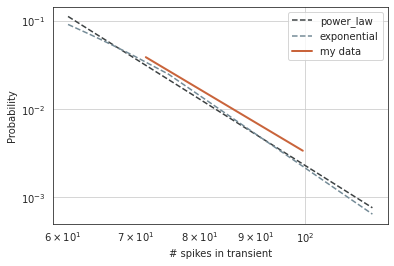

In [224]:
U.compare_distributions(data=transient_lifetime_idx, x_label='# spikes in transient')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


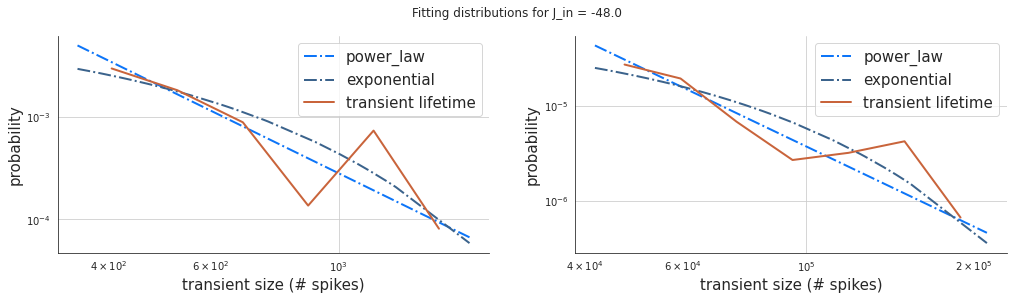

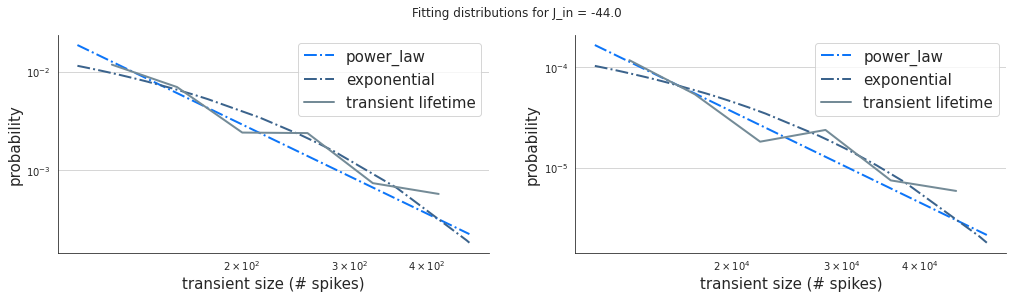

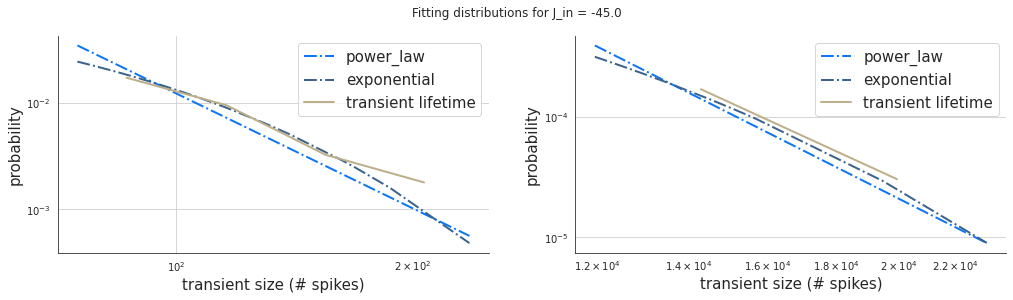

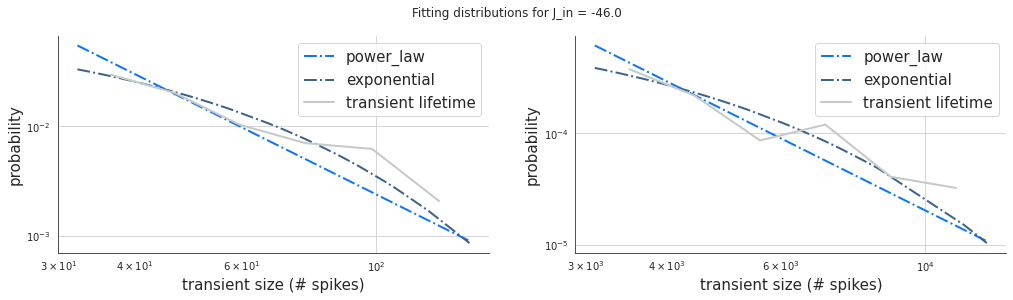

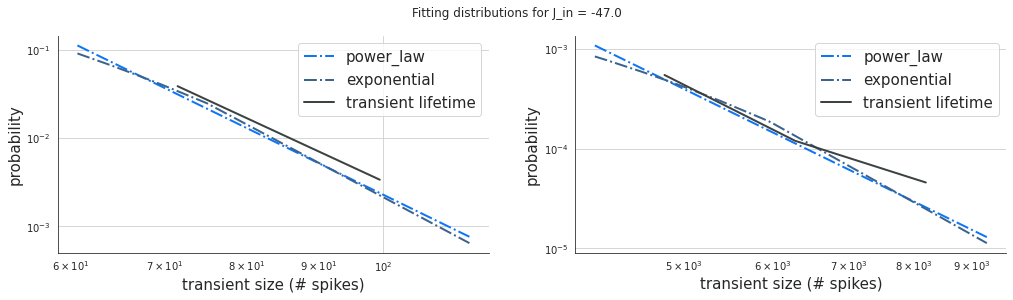

In [226]:
parameter_range = [-44.0 , -45.0, -46.0, -47.0, -48.0]
colors = ['#c9643b', '#748b97', '#beae8a', '#c5c9c7','#3c4142' ]

for i,p in enumerate(parameter_range):
    
    color=colors[i]
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17,4))
    f.suptitle(f'Fitting distributions for J_in = {value}')
    # get the right value for j_in and transient data
    value = parameter_range[i]
    transient_lifetime_idx = transient_lifetime_lst[i]
    transient_size_idx = transient_size_lst[i]

    fitTL = powerlaw.Fit(transient_lifetime_idx)

    fitTL.power_law.plot_pdf(linestyle='-.', color='#0d75f8', ax=ax1, label='power_law', linewidth=2.0)
    fitTL.exponential.plot_pdf(linestyle='-.', color='#3b638c', ax=ax1, label='exponential', linewidth=2.0)
    fitTL.plot_pdf(linewidth=2, label='transient lifetime', ax=ax1, color=color);
    ax1.set_xlabel('transient size (# spikes)', fontsize=15)
    ax1.set_ylabel('probability', fontsize=15)
    ax1.legend(fontsize=15);
    ax1.grid(True);
    # Remove top and right borders
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # ===========================
    fitTS = powerlaw.Fit(transient_size_idx)

    fitTS.power_law.plot_pdf(linestyle='-.', color='#0d75f8', ax=ax2, label='power_law', linewidth=2.0)
    fitTS.exponential.plot_pdf(linestyle='-.', color='#3b638c', ax=ax2, label='exponential', linewidth=2.0)
    fitTS.plot_pdf(linewidth=2, label='transient lifetime', ax=ax2, color=color);
    ax2.set_xlabel('transient size (# spikes)', fontsize=15)
    ax2.set_ylabel('probability', fontsize=15)
    ax2.legend(fontsize=15);
    ax2.grid(True);
    # Remove top and right borders
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)